In [1]:
# import numpy as np
# import scipy.optimize as opt
# import tensorflow as tf
# from tensorflow.examples.tutorials.mnist import input_data
# import time

# import MPO_hyperparameter_v2
# import MPO_tt_v2
# import MPO_inference_v2
import FC2_train_v2 as FC2_MPO_Net
from neural_networks import *

# import activation_functions as act
# import contractions as con

# Pre-processing

## 1. Train

In [2]:
D = 4
#threshold = 90

In [3]:
# List of layer 1 weights (0-3), layer 1 bias (4), layer 2 weights (5-8), layer 2 bias (9)
weights = FC2_MPO_Net.main(r_1=D, r_2=D)

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.
Accuracy at step 0: 0.2364
Accuracy at step 1: 0.289
Accuracy at step 2: 0.3214
Accuracy at step 3: 0.4153
Accuracy at step 9: 0.4664
Accuracy at step 11: 0.5319
Accuracy at step 12: 0.5785
Accuracy at step 13: 0.5883
Accuracy at step 14: 0.6596
Accuracy at step 15: 0.6911
Accuracy at step 26: 0.7066
Accuracy at step 27: 0.7771
A

## 2. Open weights matrices into correct MPO

In [4]:
sigma = [4, 7, 7, 4]
sigma_prime = [4, 4, 4, 4]
MPO_0, bias_0 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=0)

In [5]:
sigma = [4, 4, 4, 4]
sigma_prime = [1, 10, 1, 1]
MPO_1, bias_1 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=1)

## 3. Check that MPO is correct based on accuracy from model

In [6]:
def FC2_weights(layer_0, bias_0, layer_1, bias_1):
    data = input_data.read_data_sets("./data/",validation_size=0,one_hot=True)
    
    start = time.time()

    # temp = con.contract_horizontal(MPO_0[0], MPO_0[1], 'right')
    # temp = con.contract_horizontal(temp, MPO_0[2], 'right')
    # layer_0 = con.contract_horizontal(temp, MPO_0[3], 'right')

    # temp = con.contract_horizontal(MPO_1[0], MPO_1[1], 'right')
    # temp = con.contract_horizontal(temp, MPO_1[2], 'right')
    # layer_1 = con.contract_horizontal(temp, MPO_1[3], 'right')

    end = time.time()

    total = 10000
    correct = 0
    for i in range(0, total):
        t0 = time.time()
        xW_1 = data.test.images[i] @ layer_0# + bias_0
        xW_1 = act.ReLU(xW_1)
        result = xW_1 @ layer_1# + bias_1
        index = result.argmax()
        if index == list(data.test.labels[i]).index(1):
            correct += 1

    return correct/total*100, end-start

In [7]:
FC2(MPO_0, bias_0, MPO_1, bias_1)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


(91.10000000000001, 0.003937482833862305)

## Create new MPO with high bond dimension

In [8]:
def vector_to_left_canonical_MPS_NN(tensor, phys_dim):
    """ Decomposes a vector of length d^L (phys_dim^num_sites) into a
        left-canonical MPS. Final site will not be canonical due to
        original norm

    Args:
        tensor: Vector of length that can be described by d^L (Ex: 512 = 2^9)
        phys_dim: Physical dimension necessary on MPS at each site (d)
        num_sites: Number of sites necessary (L)

    Returns:
        A_tensors: Left canonical form of input MPS
    """

    A_tensors = []
    num_sites = len(phys_dim)
    for i in range(0, num_sites-1):
        # Remove one leg such that tensor has shape (d, d^(L-1)) with L sites
        if i == 0:
            reshaped_tensor = np.reshape(tensor, (phys_dim[i],
                                                  tensor.shape[0]//phys_dim[i]))
        else:
            reshaped_tensor = np.reshape(tensor, (A_tensors[-1].shape[1]*phys_dim[i],
                                                  tensor.shape[1]//phys_dim[i]))       
        #print("Reshape:", reshaped_tensor.shape)

        # SVD and save the rank for the next iteration of the loop
        U, S_vector, V = np.linalg.svd(reshaped_tensor, full_matrices=False)
        rank = len(S_vector)

        if i == 0:
            # No need to reshape since U is already a left-canonical matrix
            A_tensors.append(U)
        else:
            # Break apart first leg of U into a left bond dimension
            # and physical dimension
            U = np.reshape(U, (A_tensors[-1].shape[1], phys_dim[i], U.shape[1]))
            # Transpose so that we have the correct shape
            # (left bond, right bond, physical dimension)
            U = np.transpose(U, (0, 2, 1))
            A_tensors.append(U)

        # We recreate the tensor with the remaining legs
        tensor = np.diag(S_vector) @ V
    # Final A tensor is the remaining tensor after all other legs removed
    A_tensors.append(tensor.T)

    return A_tensors

In [9]:
temp = con.contract_horizontal(MPO_0[0], MPO_0[1], 'right')
temp = con.contract_horizontal(temp, MPO_0[2], 'right')
W_0 = con.contract_horizontal(temp, MPO_0[3], 'right')

temp = con.contract_horizontal(MPO_1[0], MPO_1[1], 'right')
temp = con.contract_horizontal(temp, MPO_1[2], 'right')
W_1 = con.contract_horizontal(temp, MPO_1[3], 'right')

In [10]:
vector_W0 = np.reshape(W_0, (W_0.shape[0]*W_0.shape[1]))
MPS_0 = vector_to_left_canonical_MPS_NN(vector_W0, phys_dim=[16,28,28,16])

In [11]:
vector_W1 = np.reshape(W_1, (W_1.shape[0]*W_1.shape[1]))
MPS_1 = vector_to_left_canonical_MPS_NN(vector_W1, phys_dim=[4,40,4,4])

In [12]:
MPS_0[2].shape

(448, 16, 28)

In [14]:
def compress_layer_stop(raw_state, phys_dim, threshold, compressed_state=0, plot=0, stopping_point=9):
    """ Initializes a compressed state then sweeps left->right
        and right->left until a minimum is reached
        i.e. the difference in our metrics between sweeps is less than a
        specified threshold up to the bond dimension of the raw state

        Note: Does NOT normalize the state unlike the compression function
              found in compression.py

    Args:
        raw_state: MPS to be compressed
        phys_dim: List of physical dimensions by site
        threshold: Difference between sweeps under which a solution is found
        compressed_state: Initial starting state if necessary
                          otherwise a random MPS is ini
        plot: Whether or not to plot the compression values (0 off, 1 on)

    Returns:
        compressions: Final compressed state at each bond dimension
        best_dist: List of overlap values for each bond dimension
        best_sim: List of cosine similarity values for each bond dimension
    """
    if compressed_state == 0:
        compressed_state = init.initialize_random_MPS_with_changing_phys_dim(phys_dim,
                                                                             num_sites=len(raw_state),
                                                                             bond_dim=1)
    bond_dim_raw_state = raw_state[math.ceil(len(raw_state)/2)].shape[0]
    max_bond_dim = 1

    # Initialize accuracy metrics
    dist = []  # Frobenius norm
    sim = []   # Cosine similarity (Scalar product)
    dist.append(metrics.overlap(compressed_state, raw_state))
    sim.append(metrics.scalar_product(compressed_state, raw_state))
    best_dist = []
    best_sim = []
    compressions = []
    # We sweep left to right and then back right to left across the mixed state
    while True:
        # Left->right sweep
        for site in range(0, len(raw_state)-1):
            compressed_state[site], compressed_state[site+1] = comp.update_site(compressed_state, raw_state,
                                                                           site=site, dir='right')
        # Right->left sweep
        for site in range(len(raw_state)-1, 0, -1):
            compressed_state[site], compressed_state[site-1] = comp.update_site(compressed_state, raw_state,
                                                                           site=site, dir='left')

        # Metrics taken after each sweep
        dist.append(metrics.overlap(compressed_state, raw_state))
        sim.append(metrics.scalar_product(compressed_state, raw_state))
        # Check if sweeps are still working
        if np.abs(dist[-2]-dist[-1]) < threshold:
            # Normalize to maintain length and update metrics
            #compressed_state, _ = can.left_normalize(compressed_state)
            best_dist.append((metrics.overlap(compressed_state, raw_state)))
            best_sim.append(metrics.scalar_product(compressed_state, raw_state))
            if plot == 0:
                print("Sim:", best_sim[-1], "Dist:", best_dist[-1], "BondDim:", max_bond_dim)
            compressions.append(compressed_state[:])

            # Break if we cannot increase bond dimension anymore
            if max_bond_dim+1 == bond_dim_raw_state or max_bond_dim+1 == stopping_point:
                break

            # Break if changing bond dimension did not do enough
            if len(best_dist) > 1 and np.abs(best_dist[-2]-best_dist[-1] < threshold):
                break

            # Update each tensor by increasing bond dimension
            for i, tensor in enumerate(compressed_state):
                if tensor.ndim == 2:
                    new_tensor = np.zeros((tensor.shape[0], tensor.shape[1]+1))
                    new_tensor[:tensor.shape[0], :tensor.shape[1]] = tensor
                    compressed_state[i] = new_tensor

                elif tensor.ndim == 3:
                    new_tensor = np.zeros((tensor.shape[0]+1, tensor.shape[1]+1, tensor.shape[2]))
                    new_tensor[:tensor.shape[0], :tensor.shape[1], :tensor.shape[2]] = tensor
                    compressed_state[i] = new_tensor
            max_bond_dim = compressed_state[math.ceil(len(compressed_state)/2)].shape[0]

    if plot == 1:
        max_bond_dim = range(1, len(best_dist)+1)

        plt.figure()
        plt.title("Euclidean Distance vs. Max Bond Dimension")
        plt.xlabel("Max Bond Dimension")
        plt.ylabel("Euclidean Distance")
        plt.plot(max_bond_dim, best_dist)

    return compressions, best_dist, best_sim

In [16]:
compressed_MPS_0, dist, sim = compress_layer_stop(MPS_0, phys_dim=[16,28,28,16], threshold=1e-3, plot=0, stopping_point=5)

Sim: 14.397237372349693 Dist: 47.515290805001925 BondDim: 1
Sim: 46.973250854274454 Dist: 47.1712502145319 BondDim: 2
Sim: 88.55677238974138 Dist: 46.72839955815423 BondDim: 3
Sim: 141.67116937202567 Dist: 46.156569719642555 BondDim: 4


In [17]:
compressed_MPS_1, dist, sim = compress_layer(MPS_1, phys_dim=[4, 40, 4, 4], threshold=1e-3, plot=0)

Sim: 2.4310490840864554 Dist: 6.803105606913927 BondDim: 1
Sim: 8.598157915900297 Dist: 6.333651163981947 BondDim: 2
Sim: 15.288980818209142 Dist: 5.78137649394165 BondDim: 3
Sim: 20.809917403739867 Dist: 5.282364771498679 BondDim: 4
Sim: 24.68293064934241 Dist: 4.902077552790015 BondDim: 5
Sim: 28.172141768754358 Dist: 4.5322349027997015 BondDim: 6
Sim: 31.505478982123996 Dist: 4.1482304662091956 BondDim: 7
Sim: 34.08176925794481 Dist: 3.825117740013416 BondDim: 8
Sim: 36.72813246200987 Dist: 3.4619593470894965 BondDim: 9
Sim: 39.061841093971935 Dist: 3.1066789162927977 BondDim: 10
Sim: 41.23821380736211 Dist: 2.7340594681806065 BondDim: 11
Sim: 43.1428942651856 Dist: 2.3601696374889083 BondDim: 12
Sim: 44.93760896109792 Dist: 1.9431124573251668 BondDim: 13
Sim: 46.518347154896695 Dist: 1.4815356317056554 BondDim: 14
Sim: 47.89618707699727 Dist: 0.9039402114702247 BondDim: 15


In [18]:
for i in range(len(compressed_MPS_1)):
    if i >= 7:
        j = 6
    else:
        j = i
    print(j)
    temp = con.contract_horizontal(compressed_MPS_0[j][0], compressed_MPS_0[j][1], 'right')
    temp = con.contract_horizontal(temp, compressed_MPS_0[j][2], 'right')
    layer_0 = con.contract_horizontal(temp, compressed_MPS_0[j][3], 'right')

    temp = con.contract_horizontal(compressed_MPS_1[i][0], compressed_MPS_1[i][1], 'right')
    temp = con.contract_horizontal(temp, compressed_MPS_1[i][2], 'right')
    layer_1 = con.contract_horizontal(temp, compressed_MPS_1[i][3], 'right')

    layer_0 = np.reshape(layer_0, (W_0.shape[0], W_0.shape[1]))
    layer_1 = np.reshape(layer_1, (W_1.shape[0], W_1.shape[1]))
    acc, _ = FC2_weights(layer_0, bias_0, layer_1, bias_1)
    print(acc)

0
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
10.11
1
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
17.16
2
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
20.34
3
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
28.46
4


IndexError: list index out of range

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t1

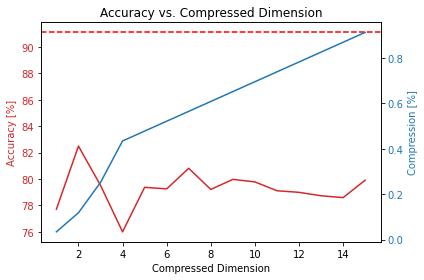

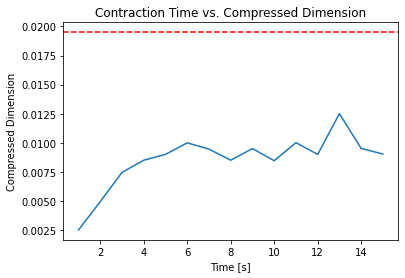

In [23]:
### Maximizing total accuracy
acc_orig, time_orig = FC2(MPS_0, bias_0, MPS_1, bias_1)

acc_compressed = []
time_compressed = []
params = []
if len(compressed_MPS_0) > len(compressed_MPS_1):
    shortest = len(compressed_MPS_1)
    longest = len(compressed_MPS_0)
else:
    shortest = len(compressed_MPS_0)
    longest = len(compressed_MPS_1)

for new_dim in range(1, longest+1):
    if new_dim < shortest:
        MPS_0_test = compressed_MPS_0[new_dim-1]
        MPS_1_test = compressed_MPS_1[new_dim-1]
    else:
        if shortest == len(compressed_MPS_0):
            MPS_0_test = compressed_MPS_0[-1]
            MPS_1_test = compressed_MPS_1[new_dim-1]
        elif shortest == len(compressed_MPS_1):
            MPS_0_test = compressed_MPS_0[new_dim-1]
            MPS_1_test = compressed_MPS_1[-1]


    ############################
    dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
    dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
    MPO_0_test = open_legs(MPS_0_test, sigma=[4,7,7,4], sigma_prime=[4,4,4,4], bond_dim=dim_0)
    MPO_1_test = open_legs(MPS_1_test, sigma=[4,4,4,4], sigma_prime=[1,10,1,1], bond_dim=dim_1)
    #MPO_1_test = open_legs(compressed_MPS_1[-1], sigma=[4,4,4,4], sigma_prime=[1,10,1,1], bond_dim=dim_1)
    total_params = 0
    for tensor in MPO_0_test:
        total_params += tensor.size
    for tensor in MPO_1_test:
        total_params += tensor.size
    params.append(total_params)

    acc, t = FC2(MPO_0_test, bias_0, MPO_1_test, bias_1)
    acc_compressed.append(acc)
    time_compressed.append(t)

    ############################

    # total_params = 0
    # for tensor in MPS_0_test:
    #     total_params += tensor.size
    # for tensor in MPS_1_test:
    #     total_params += tensor.size
    # params.append(total_params)

    # acc, t = FC2(MPS_0_test, bias_0, MPS_1_test, bias_1)
    # acc_compressed.append(acc)
    # time_compressed.append(t)

params_orig = 0
for tensor in MPS_0:
    params_orig += tensor.size
for tensor in MPS_1:
    params_orig += tensor.size

#acc_compressed.pop()
#time_compressed.pop()
#params.pop()
x = range(1, longest+1)
loss = [acc_orig-x for x in acc_compressed]
params = np.array(params)/params_orig*100


fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Compressed Dimension')
ax1.set_ylabel('Accuracy [%]', color=color)
ax1.plot(x, loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(acc_orig, color='r', linestyle='--')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Compression [%]', color=color)  # we already handled the x-label with ax1
ax2.plot(x, params, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Accuracy vs. Compressed Dimension')
fig.tight_layout()
plt.show()

plt.figure()
plt.plot(x, time_compressed)
plt.title('Contraction Time vs. Compressed Dimension')
plt.xlabel('Time [s]')
plt.ylabel('Compressed Dimension')
plt.axhline(time_orig, color='r', linestyle='--')

In [37]:
vector_W0 = np.reshape(W_0, (W_0.shape[0]*W_0.shape[1]))
MPS_0 = vector_to_left_canonical_MPS_NN(vector_W0, phys_dim=[4, 4, 28, 28, 4, 4])

vector_W1 = np.reshape(W_1, (W_1.shape[0]*W_1.shape[1]))
MPS_1 = vector_to_left_canonical_MPS_NN(vector_W1, phys_dim=[2, 2, 8, 20, 2, 2])

In [24]:
compressed_MPS_0, dist, sim = compress_NN(MPS_0, phys_dim=[4, 4, 28, 28, 4, 4], threshold=1e-3, plot=0, stopping_point=33)

Sim: 1.3703356626147831 Dist: 27.687490543548794 BondDim: 1
Sim: 17.311951510767773 Dist: 27.398093305026737 BondDim: 2
Sim: 31.121937463668935 Dist: 27.14489879881761 BondDim: 3
Sim: 46.508944988093425 Dist: 26.859979956686963 BondDim: 4
Sim: 61.36473010365755 Dist: 26.58200026630918 BondDim: 5
Sim: 77.72069932229249 Dist: 26.27254781971909 BondDim: 6
Sim: 93.4198409785553 Dist: 25.97205473741274 BondDim: 7


In [38]:
compressed_MPS_1, dist, sim = compress_NN(MPS_1, phys_dim=[2, 2, 8, 20, 2, 2], threshold=1e-3, plot=0)

Sim: 2.5599854620190756 Dist: 6.920166678611019 BondDim: 1
Sim: 8.677338051355123 Dist: 6.463076223473016 BondDim: 2
Sim: 14.959362404231928 Dist: 5.957292163185 BondDim: 3
Sim: 21.919932464888273 Dist: 5.341232054207069 BondDim: 4
Sim: 25.44064564304073 Dist: 5.00080460313504 BondDim: 5
Sim: 28.752550722735894 Dist: 4.6579117208295715 BondDim: 6
Sim: 31.34169188052708 Dist: 4.371155504125913 BondDim: 7
Sim: 33.78117459403627 Dist: 4.082587136576639 BondDim: 8
Sim: 35.95892527949691 Dist: 3.806542662611363 BondDim: 9
Sim: 38.15465723282145 Dist: 3.5062850838110515 BondDim: 10
Sim: 40.060904768274405 Dist: 3.2230090836829657 BondDim: 11
Sim: 41.408879853039636 Dist: 3.00662808952782 BondDim: 12
Sim: 42.739335580405 Dist: 2.776572840998828 BondDim: 13
Sim: 43.82037266155089 Dist: 2.5745523222934192 BondDim: 14
Sim: 44.83212237119994 Dist: 2.3699303682972177 BondDim: 15
Sim: 45.644245203839056 Dist: 2.1919049062261724 BondDim: 16
Sim: 46.39567994576426 Dist: 2.0132094714691675 BondDim: 17

In [26]:
for i in range(len(compressed_MPS_0)):
    print(i)
    if i >= 31:
        j = 31
    else:
        j = i

    temp = con.contract_horizontal(compressed_MPS_0[i][0], compressed_MPS_0[i][1], 'right')
    temp = con.contract_horizontal(temp, compressed_MPS_0[i][2], 'right')
    temp = con.contract_horizontal(temp, compressed_MPS_0[i][3], 'right')
    temp = con.contract_horizontal(temp, compressed_MPS_0[i][4], 'right')
    layer_0 = con.contract_horizontal(temp, compressed_MPS_0[i][5], 'right')

    temp = con.contract_horizontal(compressed_MPS_1[j][0], compressed_MPS_1[j][1], 'right')
    temp = con.contract_horizontal(temp, compressed_MPS_1[j][2], 'right')
    temp = con.contract_horizontal(temp, compressed_MPS_1[j][3], 'right')
    temp = con.contract_horizontal(temp, compressed_MPS_1[j][4], 'right')
    layer_1 = con.contract_horizontal(temp, compressed_MPS_1[j][5], 'right')

    layer_0 = np.reshape(layer_0, (W_0.shape[0], W_0.shape[1]))
    layer_1 = np.reshape(layer_1, (W_1.shape[0], W_1.shape[1]))
    acc, _ = FC2_weights(layer_0, bias_0, layer_1, bias_1)
    print(acc)

0
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
15.97
1
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
11.23
2
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
19.28
3
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
32.95
4
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
44.629999999999995
5
Extracting ./data/train-images-idx3-ubyte.gz
Extracting

In [27]:
def FC2_more_sites(MPO_0, bias_0, MPO_1, bias_1, W_0, W_1):
    data = input_data.read_data_sets("./data/",validation_size=0,one_hot=True)
    
    start = time.time()

    temp = con.contract_horizontal(MPO_0[0], MPO_0[1], 'right')
    temp = con.contract_horizontal(temp, MPO_0[2], 'right')
    temp = con.contract_horizontal(temp, MPO_0[3], 'right')
    temp = con.contract_horizontal(temp, MPO_0[4], 'right')
    layer_0 = con.contract_horizontal(temp, MPO_0[5], 'right')

    temp = con.contract_horizontal(MPO_1[0], MPO_1[1], 'right')
    temp = con.contract_horizontal(temp, MPO_1[2], 'right')
    temp = con.contract_horizontal(temp, MPO_1[3], 'right')
    temp = con.contract_horizontal(temp, MPO_1[4], 'right')
    layer_1 = con.contract_horizontal(temp, MPO_1[5], 'right')

    layer_0 = np.reshape(layer_0, (W_0.shape[0], W_0.shape[1]))
    layer_1 = np.reshape(layer_1, (W_1.shape[0], W_1.shape[1]))
    end = time.time()

    total = 10000
    correct = 0
    for i in range(0, total):
        t0 = time.time()
        xW_1 = data.test.images[i] @ layer_0 + bias_0
        xW_1 = act.ReLU(xW_1)
        result = xW_1 @ layer_1 + bias_1
        index = result.argmax()
        if index == list(data.test.labels[i]).index(1):
            correct += 1

    return correct/total*100, end-start

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t1

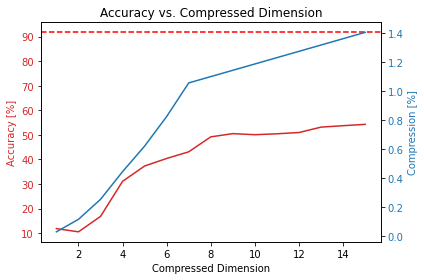

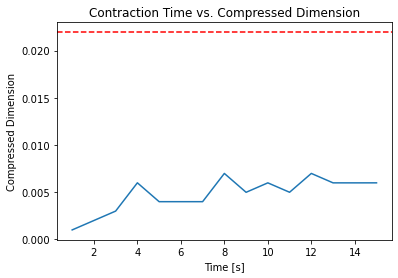

In [31]:
### Maximizing total accuracy
acc_orig, time_orig = FC2_more_sites(MPS_0, bias_0, MPS_1, bias_1, W_0, W_1)

acc_compressed = []
time_compressed = []
params = []
if len(compressed_MPS_0) > len(compressed_MPS_1):
    shortest = len(compressed_MPS_1)
    longest = len(compressed_MPS_0)
else:
    shortest = len(compressed_MPS_0)
    longest = len(compressed_MPS_1)

for new_dim in range(1, longest+1):
    if new_dim < shortest:
        MPS_0_test = compressed_MPS_0[new_dim-1]
        MPS_1_test = compressed_MPS_1[new_dim-1]
    else:
        if shortest == len(compressed_MPS_0):
            MPS_0_test = compressed_MPS_0[-1]
            MPS_1_test = compressed_MPS_1[new_dim-1]
        elif shortest == len(compressed_MPS_1):
            MPS_0_test = compressed_MPS_0[new_dim-1]
            MPS_1_test = compressed_MPS_1[-1]

    total_params = 0
    for tensor in MPS_0_test:
        total_params += tensor.size
    for tensor in MPS_1_test:
        total_params += tensor.size
    params.append(total_params)

    acc, t = FC2_more_sites(MPS_0_test, bias_0, MPS_1_test, bias_1, W_0, W_1)
    acc_compressed.append(acc)
    time_compressed.append(t)

params_orig = 0
for tensor in MPS_0:
    params_orig += tensor.size
for tensor in MPS_1:
    params_orig += tensor.size

params = np.array(params)/params_orig*100
x = range(1, longest+1)


fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Compressed Dimension')
ax1.set_ylabel('Accuracy [%]', color=color)
ax1.plot(x, acc_compressed, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(acc_orig, color='r', linestyle='--')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Compression [%]', color=color)  # we already handled the x-label with ax1
ax2.plot(x, params, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Accuracy vs. Compressed Dimension')
fig.tight_layout()
plt.show()

plt.figure()
plt.plot(x, time_compressed)
plt.title('Contraction Time vs. Compressed Dimension')
plt.xlabel('Time [s]')
plt.ylabel('Compressed Dimension')
plt.axhline(time_orig, color='r', linestyle='--')

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t1

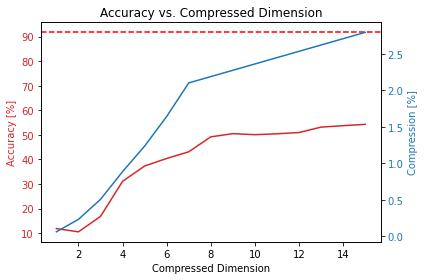

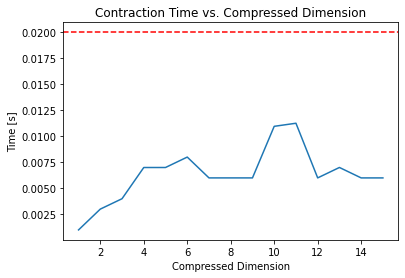

In [56]:
def open_legs(MPS, sigma, sigma_prime, bond_dim):
    """ Converts an MPS to an MPO by opening the physical dimensions

    Args:
        MPS: List of tensors of MPS
        sigma: List of input physical dimensions
        sigma_prime: List of output physical dimensions
        bond_dim: List of bond dimensions

    Returns:
        MPO: List of tensors of MPO with given dimensions
    """
    MPO = []
    for i, site in enumerate(MPS):
        if i == 0 or i == len(MPS)-1:
            site = np.reshape(site.T, (bond_dim[i], sigma[i], sigma_prime[i]))
        else:
            site = np.reshape(site, (bond_dim[i-1], bond_dim[i], sigma[i], sigma_prime[i]))
        MPO.append(site)
    return MPO

### Maximizing total accuracy
acc_orig, time_orig = FC2_more_sites(MPS_0, bias_0, MPS_1, bias_1, W_0, W_1)

acc_compressed = []
time_compressed = []
params = []
if len(compressed_MPS_0) > len(compressed_MPS_1):
    shortest = len(compressed_MPS_1)
    longest = len(compressed_MPS_0)
else:
    shortest = len(compressed_MPS_0)
    longest = len(compressed_MPS_1)

for new_dim in range(1, longest+1):
    if new_dim < shortest:
        MPS_0_test = compressed_MPS_0[new_dim-1]
        MPS_1_test = compressed_MPS_1[new_dim-1]
    else:
        if shortest == len(compressed_MPS_0):
            MPS_0_test = compressed_MPS_0[-1]
            MPS_1_test = compressed_MPS_1[new_dim-1]
        elif shortest == len(compressed_MPS_1):
            MPS_0_test = compressed_MPS_0[new_dim-1]
            MPS_1_test = compressed_MPS_1[-1]

    # dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1], MPS_0_test[4].shape[1], MPS_0_test[5].shape[1]]
    # dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1], MPS_1_test[4].shape[1], MPS_1_test[5].shape[1]]
    # MPO_0 = open_legs(MPS_0_test, sigma=[2,2,7,7,2,2], sigma_prime=[2,2,4,4,2,2], bond_dim=dim_0)
    # MPO_1 = open_legs(MPS_1_test, sigma=[2,2,4,4,2,2], sigma_prime=[1,1,10,1,1,1], bond_dim=dim_1)

    total_params = 0
    for tensor in MPS_0_test:
        total_params += tensor.size
    for tensor in MPS_1_test:
        total_params += tensor.size
    params.append(total_params)

    acc, t = FC2_more_sites(MPS_0_test, bias_0, MPS_1_test, bias_1, W_0, W_1)
    acc_compressed.append(acc)
    time_compressed.append(t)

params_orig = 0
for tensor in W_0:
    params_orig += tensor.size
for tensor in W_1:
    params_orig += tensor.size

params = np.array(params)/params_orig*100
x = range(1, longest+1)


fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Compressed Dimension')
ax1.set_ylabel('Accuracy [%]', color=color)
ax1.plot(x, acc_compressed, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(acc_orig, color='r', linestyle='--')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Compression [%]', color=color)  # we already handled the x-label with ax1
ax2.plot(x, params, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Accuracy vs. Compressed Dimension')
fig.tight_layout()
plt.show()

plt.figure()
plt.plot(x, time_compressed)
plt.title('Contraction Time vs. Compressed Dimension')
plt.xlabel('Compressed Dimension')
plt.ylabel('Time [s]')
plt.axhline(time_orig, color='r', linestyle='--')

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t1

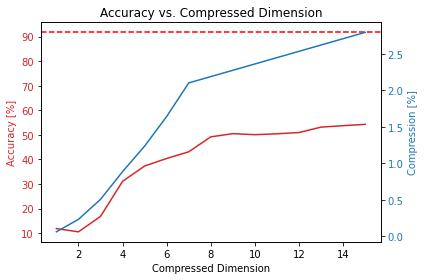

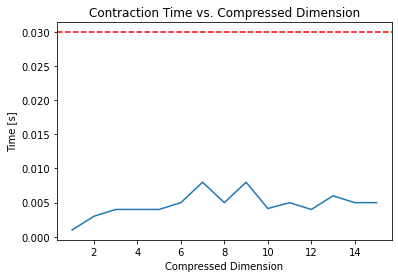

In [62]:
import neural_networks as nn

### Maximizing total accuracy
acc_orig, time_orig = nn.FC2(MPS_0, bias_0, MPS_1, bias_1)

acc_compressed = []
time_compressed = []
params = []
if len(compressed_MPS_0) > len(compressed_MPS_1):
    shortest = len(compressed_MPS_1)
    longest = len(compressed_MPS_0)
else:
    shortest = len(compressed_MPS_0)
    longest = len(compressed_MPS_1)

for new_dim in range(1, longest+1):
    if new_dim < shortest:
        MPS_0_test = compressed_MPS_0[new_dim-1]
        MPS_1_test = compressed_MPS_1[new_dim-1]
    else:
        if shortest == len(compressed_MPS_0):
            MPS_0_test = compressed_MPS_0[-1]
            MPS_1_test = compressed_MPS_1[new_dim-1]
        elif shortest == len(compressed_MPS_1):
            MPS_0_test = compressed_MPS_0[new_dim-1]
            MPS_1_test = compressed_MPS_1[-1]

    dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1], MPS_0_test[4].shape[1], MPS_0_test[5].shape[1]]
    dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1], MPS_1_test[4].shape[1], MPS_1_test[5].shape[1]]
    MPO_0 = open_legs(MPS_0_test, sigma=[2,2,7,7,2,2], sigma_prime=[2,2,4,4,2,2], bond_dim=dim_0)
    MPO_1 = open_legs(MPS_1_test, sigma=[2,2,4,4,2,2], sigma_prime=[1,1,10,1,1,1], bond_dim=dim_1)

    total_params = 0
    for tensor in MPS_0_test:
        total_params += tensor.size
    for tensor in MPS_1_test:
        total_params += tensor.size
    params.append(total_params)

    acc, t = nn.FC2(MPS_0_test, bias_0, MPS_1_test, bias_1)
    acc_compressed.append(acc)
    time_compressed.append(t)

params_orig = 0
for tensor in W_0:
    params_orig += tensor.size
for tensor in W_1:
    params_orig += tensor.size

params = np.array(params)/params_orig*100
x = range(1, longest+1)


fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Compressed Dimension')
ax1.set_ylabel('Accuracy [%]', color=color)
ax1.plot(x, acc_compressed, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(acc_orig, color='r', linestyle='--')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Compression [%]', color=color)  # we already handled the x-label with ax1
ax2.plot(x, params, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Accuracy vs. Compressed Dimension')
fig.tight_layout()
plt.show()

plt.figure()
plt.plot(x, time_compressed)
plt.title('Contraction Time vs. Compressed Dimension')
plt.xlabel('Compressed Dimension')
plt.ylabel('Time [s]')
plt.axhline(time_orig, color='r', linestyle='--')

In [65]:
FC2_more_sites(MPS_0, bias_0, MPS_1, bias_1, W_0, W_1)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


(91.69, 0.017950773239135742)

## 2. Check accuracy when compressing one layer at a time

mages-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
E

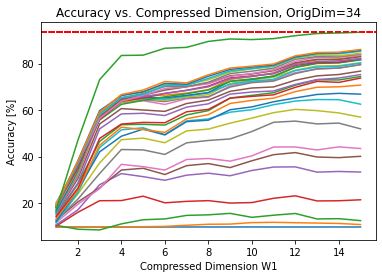

In [62]:
### Check changes in W1 for constant W0
acc_orig, _ = FC2_more_sites(MPS_0, bias_0, MPS_1, bias_1, W_0, W_1)
plt.figure()
for W0_dim in range(1, len(compressed_MPS_0)+1):
    acc_compressed = []
    time_compressed = []
    MPS_0_test = compressed_MPS_0[W0_dim-1]
    for W1_dim in range(1, len(compressed_MPS_1)+1):
        MPS_1_test = compressed_MPS_1[W1_dim-1]

        #dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
        #dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
        #MPO_0_test = open_legs(MPS_0_test, MPO_0, bond_dim=dim_0)
        #MPO_1_test = open_legs(MPS_1_test, MPO_1, bond_dim=dim_1)

        acc, t = FC2_more_sites(MPS_0_test, bias_0, MPS_1_test, bias_1, W_0, W_1)
        acc_compressed.append(acc)
        time_compressed.append(t)


    #acc_orig = acc_compressed[-1]
    #acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)
    plt.plot(range(1, len(compressed_MPS_1)), acc_compressed, label="W0_dim=%d" % W0_dim)
    plt.axhline(acc_orig, color='r', linestyle='--')
    #plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
    plt.title('Accuracy vs. Compressed Dimension, OrigDim=%d' %(len(compressed_MPS_0)+1))
    plt.xlabel('Compressed Dimension W1')
    plt.ylabel('Accuracy [%]')

In [174]:
# ### Check changes in W0 for constant W1
# plt.figure()
# for W1_dim in range(1, len(compressed_MPS_1)+1):
#     acc_compressed = []
#     time_compressed = []
#     MPS_1_test = compressed_MPS_1[W1_dim-1]
#     for W0_dim in range(1, len(compressed_MPS_0)+1):
#         MPS_0_test = compressed_MPS_0[W0_dim-1]

#         dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
#         dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
#         MPO_0_test = open_legs(MPS_0_test, MPO_0, bond_dim=dim_0)
#         MPO_1_test = open_legs(MPS_1_test, MPO_1, bond_dim=dim_1)

#         acc, t = FC2(MPO_0_test, bias_0, MPO_1_test, bias_1)
#         acc_compressed.append(acc)
#         time_compressed.append(t)


#     acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)
#     plt.plot(range(1, len(compressed_MPS_0)+1), acc_compressed, label="W1_dim=%d" % W1_dim)
#     plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
#     plt.axhline(threshold, color='r', linestyle='--')
#     plt.title('Accuracy vs. Compressed Dimension, OrigDim=%d' %(len(compressed_MPS_1)+1))
#     plt.xlabel('Compressed Dimension W0')
#     plt.ylabel('Accuracy [%]')

## 3. Heatmap of accuracy by layer dimension

In [176]:
acc_orig, time_orig = FC2_more_sites(MPO_0, bias_0, MPO_1, bias_1)
acc_matrix = []
for W0_dim in range(1, len(compressed_MPS_0)+1):
    acc_array = []
    MPS_0_test = compressed_MPS_0[W0_dim-1]
    for W1_dim in range(1, len(compressed_MPS_1)+1):
        MPS_1_test = compressed_MPS_1[W1_dim-1]

        dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1], MPS_0_test[4].shape[1], MPS_0_test[5].shape[1]]
        dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1], MPS_1_test[4].shape[1], MPS_1_test[5].shape[1]]
        MPO_0_test = open_legs(MPS_0_test, MPO_0, bond_dim=dim_0)
        MPO_1_test = open_legs(MPS_1_test, MPO_1, bond_dim=dim_1)

        acc, _ = FC2_more_sites(MPO_0_test, bias_0, MPO_1_test, bias_1)
        acc_array.append(acc)
    acc_matrix.append(acc_array)
# fig, ax = plt.subplots()
# im = ax.imshow(acc_matrix, cmap='inferno_r')

# # We want to show all ticks...
# ax.set_xticks(np.arange(len(compressed_MPS_0)+1))
# ax.set_yticks(np.arange(len(compressed_MPS_1)+1))
# # ... and label them with the respective list entries
# ax.set_xticklabels(np.arange(1, len(compressed_MPS_0)+1))
# ax.set_yticklabels(np.arange(1, len(compressed_MPS_1)+1))

# # Rotate the tick labels and set their alignment.
# # plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
# #          rotation_mode="anchor")

# plt.xlabel('W0 Dimension')
# plt.ylabel('W1 Dimension')
# plt.title('Loss vs. Compressed Dimensions, OrigDim=%d' % D)
# Loop over data dimensions and create text annotations.
# for i in range(len(compressed_MPS_0)):
#     for j in range(len(compressed_MPS_1)):
#         text = ax.text(j, i, np.round(acc_matrix[i][j], 2),
#                        ha="center", va="center", color="w")

g ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
(784, 256)
(256, 10)
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
(784, 256)
(256, 10)
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
(784, 256)
(256, 10)
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
(784, 256)
(256, 10)
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
(784, 256)
(256, 10)
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./d

## 4. Compression ratio for layer dimensions

In [177]:
orig_params = calculate_params(MPS_0)+calculate_params(MPS_1)
params_matrix = []
compression_ratio_matrix = []
for i in range(len(compressed_MPS_0)):
    compression_ratio = []
    for j in range(len(compressed_MPS_1)):
        params = calculate_params(compressed_MPS_0[i]) + calculate_params(compressed_MPS_1[j])
        compression_ratio.append(round(params/orig_params*100, 2))
    compression_ratio_matrix.append(compression_ratio)

# fig, ax = plt.subplots()
# im = ax.imshow(compression_ratio_matrix, cmap='inferno_r')

# ax.set_xticks(np.arange(len(compressed_MPS_0)+1))
# ax.set_yticks(np.arange(len(compressed_MPS_1)+1))
# ax.set_xticklabels(np.arange(1, len(compressed_MPS_0)+1))
# ax.set_yticklabels(np.arange(1, len(compressed_MPS_1)+1))

# plt.xlabel('W0 Dimension')
# plt.ylabel('W1 Dimension')
# plt.title('Compression Ratio vs. Compressed Dimensions, OrigDim=%d' % D)

# # Loop over data dimensions and create text annotations.
# for i in range(len(compressed_MPS_0)):
#     for j in range(len(compressed_MPS_1)):
#         text = ax.text(j, i, np.round(compression_ratio_matrix[i][j], 2),
#                        ha="center", va="center", color="w")

## 5. Compression ratio for accuracy above threshold 

Layers cannot be compressed and still reach given threshold


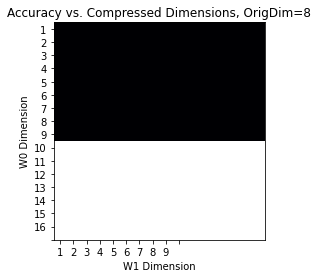

In [178]:
compression_ratio_plot = np.array(compression_ratio_matrix[:])
acc_matrix_plot = np.array(acc_matrix[:])
compression_ratio_plot[acc_matrix_plot < threshold] = 0

fig, ax = plt.subplots()
im = ax.imshow(compression_ratio_plot, cmap='inferno')
ax.set_xticks(np.arange(len(compressed_MPS_0)+1))
ax.set_yticks(np.arange(len(compressed_MPS_1)+1))
ax.set_xticklabels(np.arange(1, len(compressed_MPS_0)+1))
ax.set_yticklabels(np.arange(1, len(compressed_MPS_1)+1))

plt.xlabel('W1 Dimension')
plt.ylabel('W0 Dimension')
plt.title('Accuracy vs. Compressed Dimensions, OrigDim=%d' % D)
try:
    minval = np.min(compression_ratio_plot[np.nonzero(compression_ratio_plot)])
    ij = np.where(compression_ratio_plot == minval)
    plt.plot(ij[1], ij[0], 'wX')
    print("Best Compression:", minval, "%")
    print("W0_dim = ", ij[0][0]+1)
    print("W1_dim = ", ij[1][0]+1)
except:
    print("Layers cannot be compressed and still reach given threshold")


# Loop over data dimensions and create text annotations.
# for i in range(len(compressed_MPS_0)):
#     for j in range(len(compressed_MPS_1)):
#         text = ax.text(j, i, np.round(compression_ratio_matrix[i][j], 2),
#                        ha="center", va="center", color="w")